__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 30 янв 2023 12:17:23 MSK


In [2]:
# !pip install plotly ipywidgets plotly-geo

In [3]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [5]:
# !ls -1 data

In [6]:
# import shapely
# shapely.__version__
# '1.8.4'

In [7]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

In [8]:
# !pip install --upgrade pip

In [9]:
# !pip install --upgrade pygeos==0.10.2

In [10]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

## считываем данные

In [11]:
data_file = 'data/data_flat.pkl'

In [12]:
cols = ['title','adr','latitude','longitude','priceM','dt']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

48341


,title,adr,latitude,longitude,priceM,dt
33362,"3-комн. кв., 124 м², 3/8 этаж","Севастополь, район Гагаринский, Омега, проспект Античный, 4",44.595028,33.44223,24.90,2022-09-22
17508,"2-к. квартира, 55,2 м², 4/9 эт.","Севастополь, улица Павла Корчагина, д. 23, блок-секция 1",44.584462,33.435097,10.69,2022-09-13
19940,"3-к. квартира, 76,5 м², 3/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 1",44.586446,33.503073,10.33,2022-09-26


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48341 entries, 0 to 48340
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          48341 non-null  object        
 1   price          48341 non-null  int64         
 2   adr_orig       48341 non-null  object        
 3   description    48341 non-null  object        
 4   obj_name       48341 non-null  object        
 5   ts             48341 non-null  datetime64[ns]
 6   avito_page     24230 non-null  float64       
 7   place          48341 non-null  object        
 8   nrooms         48341 non-null  int64         
 9   floor          48341 non-null  int64         
 10  nfloors        48341 non-null  int64         
 11  area           48341 non-null  float64       
 12  is_studio      48341 non-null  bool          
 13  is_apartment   48341 non-null  bool          
 14  is_part        48341 non-null  bool          
 15  is_auction     4834

In [14]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )


# gdf[ gdf['title'].str.lower().str.match(r'дом 2'latitude','longitude'23,2.*') ]
df.loc[ df['adr_orig']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['adr_orig'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

In [15]:
# берём объявления с геометкой
print(len(df))
df = df[ 
    ~( df['latitude'].isnull()| df['longitude'].isnull() ) 
].reset_index(drop=True)
print(len(df))

48341
48341


In [16]:
# # берём объявления с геометкой
# print(len(df))
# df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
# print(len(df))

### ограничиваем тип объекта 

In [17]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
print(len(df))

48341
42081
42080


In [18]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
35669,"3-комн. кв., 72 м², 1/9 этаж","Севастополь, район Гагаринский, Летчики, улица Колобова, 15",44.58,33.46,9.50
23103,"2-к. квартира, 59 м², 2/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 2",44.58,33.50,8.26
20908,"1-к. квартира, 35,5 м², 1/11 эт.","Севастополь, проспект Столетовский, д. 27",44.58,33.46,5.50


In [19]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '1-к. квартира, 16\xa0м², 3/3\xa0эт.',
  'adr': 'Севастополь, проезд Якова Иванова, 13',
  'url': 'https://avito.ru/2489488931'},
 {'title': '2-комн. кв., 64,9 м², 1/3 этаж',
  'adr': 'Севастополь, район Гагаринский, улица Парковая, 8/26',
  'url': 'https://sevastopol.cian.ru/sale/flat/277795934/'},
 {'title': '1-комн. кв., 31 м², 9/9 этаж',
  'adr': 'Севастополь, район Гагаринский, Камышовая бухта, улица Бориса Михайлова, 5',
  'url': 'https://sevastopol.cian.ru/sale/flat/277150171/'},
 {'title': '3-к. квартира, 85,6\xa0м², 4/8\xa0эт.',
  'adr': 'Севастополь, улица Павла Корчагина, стр. 7',
  'url': 'https://avito.ru/2392213875'},
 {'title': '3-комн. кв., 75,5 м², 1/10 этаж',
  'adr': 'Севастополь, район Ленинский, Острякова, улица Хрусталева, 179',
  'url': 'https://sevastopol.cian.ru/sale/flat/275843022/'},
 {'title': '1-к. квартира, 38,7\xa0м², 7/9\xa0эт.',
  'adr': 'Севастополь, улица Павла Корчагина, д. 23, блок-секция 1',
  'url': 'https://avito.ru/2365948658'},
 {'ti

In [20]:
del df

In [21]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика

### количество предложений

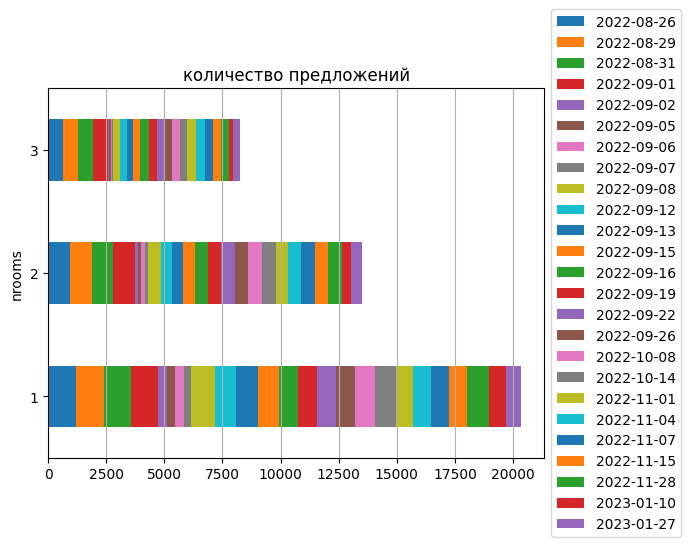

In [22]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

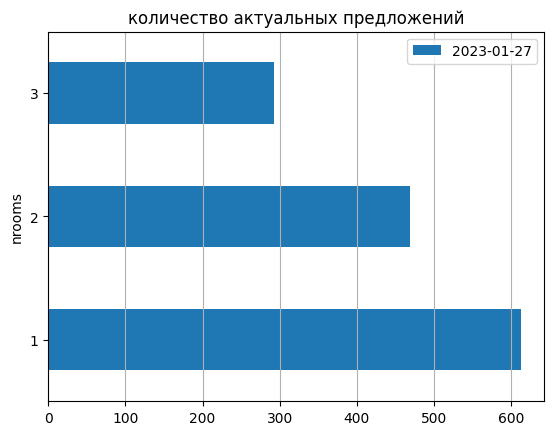

In [23]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений') #, stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [24]:
stat = gdf.groupby(['nrooms','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

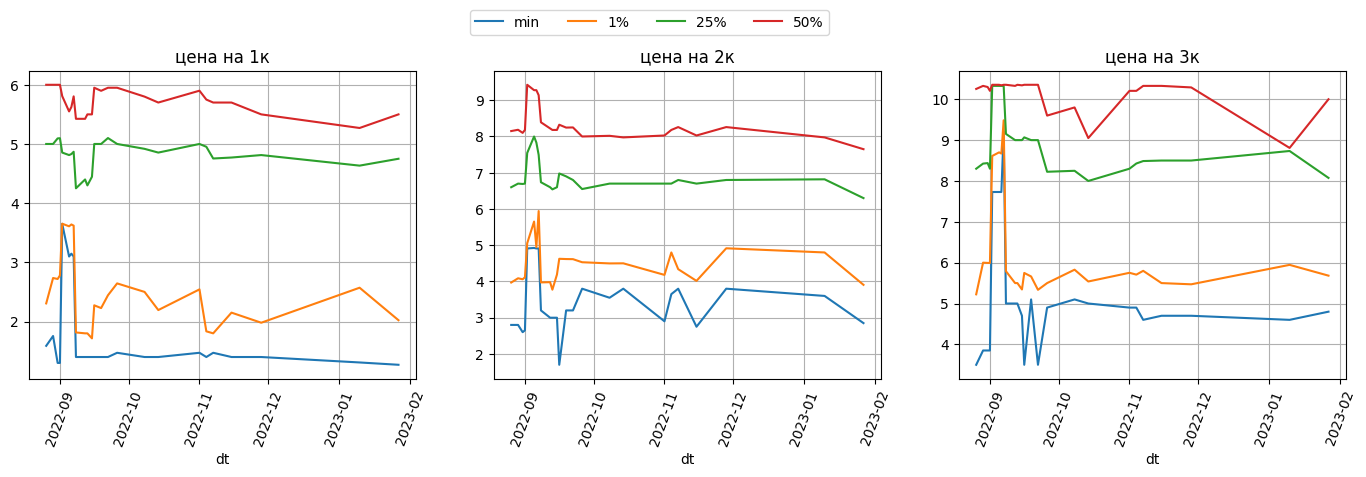

In [25]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [26]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()


In [27]:
# frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

In [28]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [29]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
16,862d2880fffffff,"POLYGON ((33.64817 44.50734, 33.62675 44.47788, 33.65358 44.44905, 33.70180 44.44966, 33.72323 44.47910, 33.69643 44.50794, 33.64817 44.50734))"
4,862d2882fffffff,"POLYGON ((33.57303 44.53552, 33.55163 44.50606, 33.57850 44.47724, 33.62675 44.47788, 33.64817 44.50734, 33.62132 44.53616, 33.57303 44.53552))"


In [30]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [31]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [32]:
frames.explore('area_name', legend=True)

In [33]:
# frames.to_file('data/frames.geojson', driver='GeoJSON')

In [34]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

42080
3516


In [35]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [36]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

In [37]:
locations = ' | '.join(area_name)
locations

'Севастополь, район Острякова'

### количество предложений

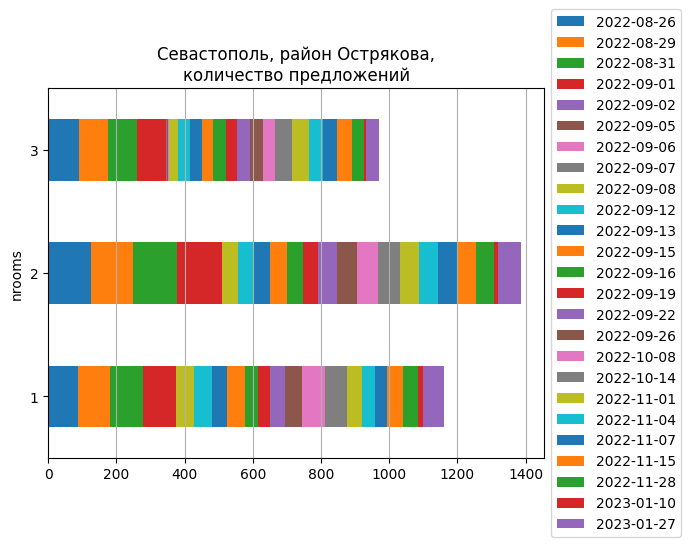

In [38]:
fig = ( # количество предложений
    gdf_.groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

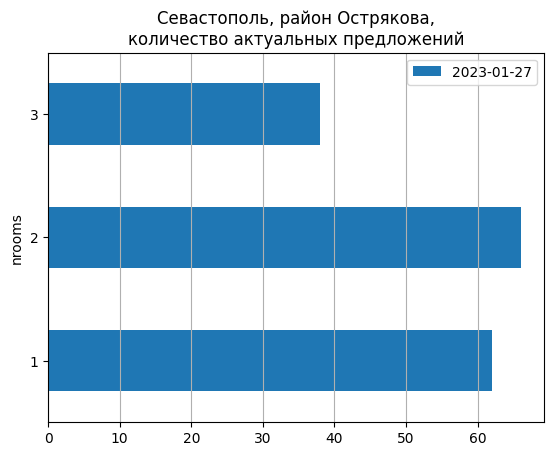

In [39]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество актуальных предложений',stacked=True)

)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [40]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

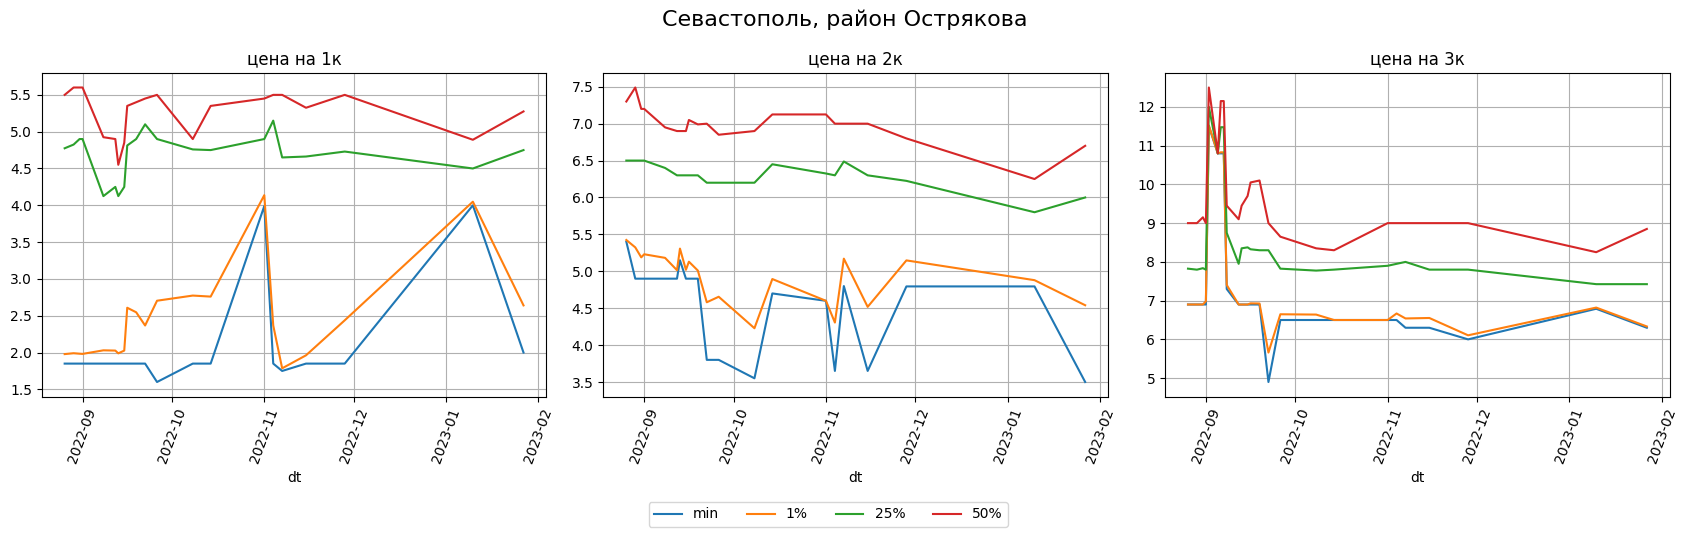

In [41]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
    
fig.suptitle(locations, fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

### гексагональная сетка и  медиана актуальной цены

In [42]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
45,892d289405bffff,"POLYGON ((33.51520 44.58354, 33.51487 44.58175, 33.51696 44.58059, 33.51937 44.58122, 33.51969 44.58301, 33.51761 44.58417, 33.51520 44.58354))"
25,892d289518bffff,"POLYGON ((33.53280 44.55402, 33.53247 44.55223, 33.53456 44.55107, 33.53697 44.55170, 33.53729 44.55349, 33.53521 44.55465, 33.53280 44.55402))"


In [43]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)